epoch:  1
Action/state =  [-0.00350162]
Objective function:  [-0.260978]
Theta0:  [1000.00000027]
Theta1:  [-0.00149947]
Theta2:  [-0.00149902]
Theta3:  [-0.00150099]
Theta4:  [-0.00158334]
Theta5:  [-0.00367955]
Theta_sigma:  [399.99999616]
Steps taken:  100


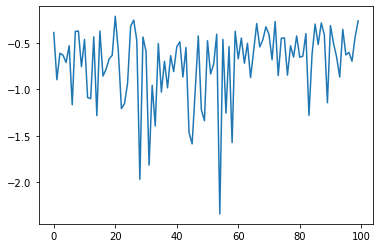

epoch:  1
Action/state =  [-0.00342539]
Objective function:  [-0.29489415]
Theta0:  [1000.00000023]
Theta1:  [-0.00149961]
Theta2:  [-0.00149947]
Theta3:  [-0.00150225]
Theta4:  [-0.00158249]
Theta5:  [-0.00359519]
Theta_sigma:  [399.99999232]
Steps taken:  200


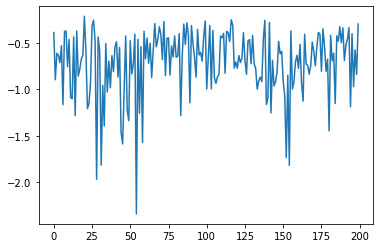

KeyboardInterrupt: 

In [1]:
import numpy as np
import scipy
from scipy import stats
from copy import deepcopy
import math
import random as rn
import matplotlib.pyplot as plt

global_max=0

# Order Book for Hedging Class
class LOB:   
    def __init__(self, midprice, volatility, perm_impact, spread, bp_distance):
        self.midprice = midprice
        self.volatility = volatility
        self.perm_impact = perm_impact
        self.spread = spread
        self.bp_distance = bp_distance
    
    def price_update(self, hedging_amount):
        dt_sec = 1
        random_bps = np.random.normal(0, self.volatility * np.sqrt(dt_sec/86400))
        psi = 0.1; eta = 1e-5; pmi = 0.005
        size = hedging_amount*dt_sec/86400
        cost = 1e-4*np.sign(hedging_amount) * (psi + eta * np.abs(hedging_amount))
        impact_bps = pmi*size
        dS = 1e-4 * (impact_bps + random_bps)
        self.midprice += dS
        return dS
        
    def market_impact(self, hedging_amount):      
        return hedging_amount/(10**6) * 0.5 

    
# Market-Maker Class
class MarketMaker:
    def __init__(self, theta0, theta1, theta2, theta3, theta4, theta5, theta_sigma, inventory):
        self.theta0 = theta0
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3
        self.theta4 = theta4
        self.theta5 = theta5
        self.theta_sigma = theta_sigma
        self.inventory = inventory

    def policy_output(self):
        sign=np.sign(self.inventory[0])
        mu = (self.theta0 + self.theta1 * abs(self.inventory[0])**(1/5) + self.theta2 * abs(self.inventory[0])**(2/5) \
              + self.theta3 * abs(self.inventory[0])**(3/5) + self.theta4 * abs(self.inventory[0])**(4/5) \
              + self.theta5 * abs(self.inventory[0]))*sign
        sigma = self.theta_sigma
        hedging_amount = np.random.normal(loc = mu, scale = sigma, size = 1)[0] 
        return hedging_amount
         
    def reward_output(self, market_impact, price_change, spread, volatility, mm_profit, hedging_amount): 
        reward = mm_profit + (self.inventory + hedging_amount) * price_change - abs(self.inventory + hedging_amount) * volatility - abs(hedging_amount) * (spread * 0.5 + market_impact)       
        return reward

    
class Client_Trader():
    def __init__(self):
        self.nothing = 0
 
    def getAmount(self):
        amountsList = [1000000, 3000000, 5000000]
        p = [0.8,  0.15, 0.05]
        idx = np.random.choice(len(p), p=p)
        amount = np.array(rn.choice([-1,1]) * amountsList[idx])
        return np.array([float(amount)])
        
    

def gradient_log(theta0, theta1, theta2, theta3, theta4, theta5, theta_sigma, inventory, hedging_amount): # sigma = theta2
    
    sign=np.sign(inventory)
    
    gr0 = sign * (hedging_amount - sign*(theta0 + theta1 * abs(inventory)**(1/5) + theta2 * abs(inventory)**(2/5) \
                      + theta3 * abs(inventory)**(3/5) + theta4 * abs(inventory)**(4/5) + theta5 * abs(inventory))) \
               /(theta_sigma**2)
    gr1 = sign * abs(inventory)**(1/5) * (hedging_amount - sign*(theta0 + theta1 * abs(inventory)**(1/5) + theta2 * abs(inventory)**(2/5) \
                      + theta3 * abs(inventory)**(3/5) + theta4 * abs(inventory)**(4/5) + theta5 * abs(inventory))) \
                               /(theta_sigma**2)
    gr2 = sign * abs(inventory)**(2/5) * (hedging_amount - sign*(theta0 + theta1 * abs(inventory)**(1/5) + theta2 * abs(inventory)**(2/5) \
                      + theta3 * abs(inventory)**(3/5) + theta4 * abs(inventory)**(4/5) + theta5 * abs(inventory))) \
                               /(theta_sigma**2)
    gr3 = sign * abs(inventory)**(3/5) * (hedging_amount - sign*(theta0 + theta1 * abs(inventory)**(1/5) + theta2 * abs(inventory)**(2/5) \
                      + theta3 * abs(inventory)**(3/5) + theta4 * abs(inventory)**(4/5) + theta5 * abs(inventory))) \
                               /(theta_sigma**2)
    gr4 = sign * abs(inventory)**(4/5) * (hedging_amount - sign*(theta0 + theta1 * abs(inventory)**(1/5) + theta2 * abs(inventory)**(2/5) \
                      + theta3 * abs(inventory)**(3/5) + theta4 * abs(inventory)**(4/5) + theta5 * abs(inventory))) \
                               /(theta_sigma**2)
    gr5 = sign * abs(inventory) * (hedging_amount - sign*(theta0 + theta1 * abs(inventory)**(1/5) + theta2 * abs(inventory)**(2/5) \
                      + theta3 * abs(inventory)**(3/5) + theta4 * abs(inventory)**(4/5) + theta5 * abs(inventory))) \
                        /(theta_sigma**2)
    gr_sigma = -1/theta_sigma + (hedging_amount - sign*(theta0 + theta1 * abs(inventory)**(1/5) + theta2 * abs(inventory)**(2/5) \
                      + theta3 * abs(inventory)**(3/5) + theta4 * abs(inventory)**(4/5) + theta5 * abs(inventory))**2) \
                                  /(theta_sigma**3)
    return [gr0, gr1, gr2, gr3, gr4, gr5, gr_sigma]   

def v_approximarion(weights, state):
    result = weights[0]
    for i in range(1, 6): 
        result += weights[i] * np.cos(np.pi*i*state/10e6)
    for i in range(6, 11): 
        result += weights[i] * np.sin(np.pi*(i-5)*state/10e6)
    return result
        
def gradient_v(state): 
    gv0=1
    gv1=np.cos(np.pi*1*state/10e6)
    gv2=np.cos(np.pi*2*state/10e6)
    gv3=np.cos(np.pi*3*state/10e6)
    gv4=np.cos(np.pi*4*state/10e6)
    gv5=np.cos(np.pi*5*state/10e6)
    gv6=np.sin(np.pi*1*state/10e6)
    gv7=np.sin(np.pi*2*state/10e6)
    gv8=np.sin(np.pi*3*state/10e6)
    gv9=np.sin(np.pi*4*state/10e6)
    gv10=np.sin(np.pi*5*state/10e6)
    return [gv0, gv1, gv2, gv3, gv4, gv5, gv6, gv7, gv8, gv9, gv10]

objecttt = []

for epoch in range(100):

    midprice = 1
    perm_impact = 0.005
    bp_distance = 1/10000
    volatility = 50 * bp_distance
    spread = 5 * bp_distance
    theta0 = 1000
    theta1 = -0.0015
    theta2 = -0.0015
    theta3 = -0.0015
    theta4 = -0.0015
    theta5 = -0.0015
    theta_sigma = 400
    weights = [1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
    inventory = 0
    hedging_amount = 0 


    # Initial parameters for training (subject to change):
    grad_J = [+np.inf, +np.inf, +np.inf, +np.inf, +np.inf, +np.inf, +np.inf] 
    norm_grad_J = (grad_J[0]**2 + grad_J[1]**2 + grad_J[2]**2 + grad_J[3]**2 + grad_J[4]**2 + \
                   grad_J[5]**2 + grad_J[6]**2)**0.5 
    time = 600
    alpha = 2**(-10)
    beta = 2**(-10)
    gamma = 0.995
    theta1_benchmark = -10**(-6)
    theta2_benchmark = 10**(-5)
    steps = 0
    objective_values = []

    Order_book = LOB(midprice, volatility, perm_impact, spread, bp_distance)
    Client = Client_Trader()
    Market_Maker = MarketMaker(theta0, theta1, theta2, theta3, theta4, theta5, theta_sigma, inventory)


    while steps<1600:

        check = []
        states = [] 
        actions = [] 
        rewards = [] 
        Order_book.midprice = 1 
        Market_Maker.inventory = 0 
        mm_profit = 0 
        avg_price = 0 
        for i in range(time):    
            # LOB updates based on our previous actions
            price_delta = Order_book.price_update(hedging_amount) 

            # Client trades x
            x = Client.getAmount() 
            check.append(x)



            if Market_Maker.inventory > 0: 
                if x > 0: 
                    priceWithSpread = Order_book.midprice + (spread/2)
                    if x <= Market_Maker.inventory:
                        mm_profit = x * (priceWithSpread - avg_price)
                        Market_Maker.inventory -= x 
                    else:
                        mm_profit = Market_Maker.inventory * (priceWithSpread - avg_price)
                        Market_Maker.inventory -= x 
                        avg_price = deepcopy(priceWithSpread)
                else: 
                    mm_profit = 0
                    priceWithSpread = Order_book.midprice - (spread/2)
                    Market_Maker.inventory -= x 
                    avg_price = (avg_price * (Market_Maker.inventory-abs(x)) + deepcopy(priceWithSpread) * abs(x))/Market_Maker.inventory

            elif Market_Maker.inventory < 0: 
                if x < 0: 
                    priceWithSpread = Order_book.midprice - (spread/2)
                    if abs(x) <= abs(Market_Maker.inventory): 
                        mm_profit = x * (avg_price - priceWithSpread)
                        Market_Maker.inventory -= x 
                    else:
                        mm_profit = Market_Maker.inventory * (avg_price - priceWithSpread)
                        Market_Maker.inventory -= x 
                        avg_price = deepcopy(priceWithSpread)
                else: 
                    mm_profit = 0
                    priceWithSpread = Order_book.midprice + (spread/2)
                    Market_Maker.inventory -= x 
                    avg_price = (avg_price * abs(Market_Maker.inventory+x) + x * priceWithSpread)/abs(Market_Maker.inventory)    
            else: 
                if x < 0: 
                    avg_price = Order_book.midprice - (spread/2)
                if x > 0:
                    avg_price = Order_book.midprice + (spread/2)
                else:
                    avg_price = 0    
                Market_Maker.inventory -= x
                mm_profit = 0


            inventory = deepcopy(Market_Maker.inventory)
            hedging_amount = Market_Maker.policy_output() 
            mi = Order_book.market_impact(hedging_amount) # MI
            R = Market_Maker.reward_output(mi, price_delta, spread, volatility, mm_profit, hedging_amount)/(10**10)
            states.append(inventory)
            actions.append(hedging_amount)
            rewards.append(R)   
            Market_Maker.inventory += hedging_amount

        if abs(sum(check)) > 100e6:
            continue

        # Returns on trajectory (G_k)
        G = []
        for i in range(len(rewards)): 
            g_k = 0
            for j in range(i, len(rewards)): 
                g_k += rewards[j] * gamma**(j - i)
            G.append(g_k)





        objective_values.append(sum(G))

        for i in range(len(G)):
            delta = G[i] - v_approximarion(weights, states[i])
            norm_grad=(gradient_v(states[i])[0]**2 + gradient_v(states[i])[1]**2 + \
                       gradient_v(states[i])[2]**2 + gradient_v(states[i])[3]**2 + gradient_v(states[i])[4]**2 + \
                       gradient_v(states[i])[5]**2 + gradient_v(states[i])[6]**2 + gradient_v(states[i])[7]**2 + \
                       gradient_v(states[i])[8]**2 + gradient_v(states[i])[9]**2 + gradient_v(states[i])[10]**2)**0.5
            for j in range(len(weights)):
                 weights[j] += beta * delta * gradient_v(states[i])[j]/norm_grad

            temp = gradient_log(Market_Maker.theta0, Market_Maker.theta1, Market_Maker.theta2, Market_Maker.theta3 \
                                , Market_Maker.theta4, Market_Maker.theta5, Market_Maker.theta_sigma, states[i], actions[i])
            norm_temp=(temp[0]**2+temp[1]**2+temp[2]**2+temp[3]**2+temp[4]**2+temp[5]**2+temp[6]**2)**0.5
            Market_Maker.theta0 = Market_Maker.theta0 + alpha * (gamma**i) * delta * temp[0]/norm_temp
            Market_Maker.theta1 = Market_Maker.theta1 + alpha * (gamma**i) * delta * temp[1]/norm_temp
            Market_Maker.theta2 = Market_Maker.theta2 + alpha * (gamma**i) * delta * temp[2]/norm_temp
            Market_Maker.theta3 = min(0, Market_Maker.theta3 + alpha * (gamma**i) * delta * temp[3]/norm_temp)
            Market_Maker.theta4 = min(0, Market_Maker.theta4 + alpha * (gamma**i) * delta * temp[4]/norm_temp)
            Market_Maker.theta5 = min(0, Market_Maker.theta5 + alpha * (gamma**i) * delta * temp[5]/norm_temp)
            Market_Maker.theta_sigma = max(1, Market_Maker.theta_sigma + alpha * (gamma**i) * delta * temp[6]/norm_temp)


        steps += 1    

        if steps % 100 == 0:
            print('epoch: ', epoch+1)
            print('Action/state = ', actions[-1]/states[-1])
            print('Objective function: ', objective_values[-1])
            print('Theta0: ', Market_Maker.theta0)
            print('Theta1: ', Market_Maker.theta1)
            print('Theta2: ', Market_Maker.theta2)
            print('Theta3: ', Market_Maker.theta3)
            print('Theta4: ', Market_Maker.theta4)
            print('Theta5: ', Market_Maker.theta5)
            print('Theta_sigma: ', Market_Maker.theta_sigma)
            print('Steps taken: ', steps)
            plt.plot(range(steps), objective_values)
            plt.show()
            print('==============================================')
            
            
    objecttt.append(objective_values) #EXPORT AFTER SIMULATION